In [1]:
import os
os.environ['CUDA_VISIBLE_DEVICES'] = "0"
from numpy.random import seed
seed(20)  ##15 for left canal
import google.protobuf

import gast
import tensorflow as tf
tf.random.set_seed(20) ##32 for training 1
from tensorflow.python.client import device_lib 
print(device_lib.list_local_devices())
tf.test.is_gpu_available()

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 12828664376980575656
xla_global_id: -1
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 40074543104
locality {
  bus_id: 1
  links {
  }
}
incarnation: 17956998357348158415
physical_device_desc: "device: 0, name: NVIDIA A100-PCIE-40GB, pci bus id: 0000:5e:00.0, compute capability: 8.0"
xla_global_id: 416903419
]
Instructions for updating:
Use `tf.config.list_physical_devices('GPU')` instead.


2023-08-24 13:22:33.115292: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-08-24 13:22:34.111372: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1525] Created device /device:GPU:0 with 38218 MB memory:  -> device: 0, name: NVIDIA A100-PCIE-40GB, pci bus id: 0000:5e:00.0, compute capability: 8.0
2023-08-24 13:22:34.122976: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1525] Created device /device:GPU:0 with 38218 MB memory:  -> device: 0, name: NVIDIA A100-PCIE-40GB, pci bus id: 0000:5e:00.0, compute capability: 8.0


True

In [2]:
import cv2
import glob
import random
from tqdm import tqdm
import skimage.io as io
import cv2
import skimage.transform as trans
import numpy as np
import matplotlib.pyplot as plt
import pydicom
import SimpleITK as sitk
import nibabel as nib
from scipy import ndimage

def dice_coef(y_true,y_pred, loss_type='jaccard', smooth=1.):

    y_true_f = tf.reshape(y_true,[-1])
    y_pred_f = tf.reshape(y_pred,[-1])

    intersection = tf.reduce_sum(y_true_f * y_pred_f)

    if loss_type == 'jaccard':
        union = tf.reduce_sum(tf.square(y_pred_f)) + tf.reduce_sum(tf.square(y_true_f))

    elif loss_type == 'sorensen':
        union = tf.reduce_sum(y_pred_f) + tf.reduce_sum(y_true_f)

    else:
        raise ValueError("Unknown `loss_type`: %s" % loss_type)

    return (2. * intersection + smooth) / (union + smooth)

def dice_loss(y_true,y_pred, loss_type='jaccard', smooth=1.):

    y_true_f = tf.cast(tf.reshape(y_true,[-1]),tf.float32)
    y_pred_f =tf.cast(tf.reshape(y_pred,[-1]),tf.float32)

    intersection = tf.reduce_sum(y_true_f * y_pred_f)

    if loss_type == 'jaccard':
        union = tf.reduce_sum(tf.square(y_pred_f)) + tf.reduce_sum(tf.square(y_true_f))

    elif loss_type == 'sorensen':
        union = tf.reduce_sum(y_pred_f) + tf.reduce_sum(y_true_f)

    else:
        raise ValueError("Unknown `loss_type`: %s" % loss_type)

    return (1-(2. * intersection + smooth) / (union + smooth))

def compute_dice(im1, im2, empty_score=1.0):
    """
    Computes the Dice coefficient, a measure of set similarity.
    Parameters
    ----------
    im1 : array-like, bool
        Any array of arbitrary size. If not boolean, will be converted.
    im2 : array-like, bool
        Any other array of identical size. If not boolean, will be converted.
    Returns
    -------
    dice : float
        Dice coefficient as a float on range [0,1].
        Maximum similarity = 1
        No similarity = 0
        Both are empty (sum eq to zero) = empty_score
    Notes
    -----
    The order of inputs for `dice` is irrelevant. The result will be
    identical if `im1` and `im2` are switched.
    """
    im1 = np.asarray(im1).astype(np.bool)
    im2 = np.asarray(im2).astype(np.bool)

    if im1.shape != im2.shape:
        raise ValueError("Shape mismatch: im1 and im2 must have the same shape.")

    im_sum = im1.sum() + im2.sum()
    if im_sum == 0:
        return empty_score

    # Compute Dice coefficient
    intersection = np.logical_and(im1, im2)

    return 2. * intersection.sum() / im_sum

import copy
def get_normalized(scann,mn,mx):
    scan = copy.copy(scann)
    mn = max(mn,np.amin(scan))
    mx = min(mx,np.amax(scan))
    np.clip(scan, mn, mx, out=scan)
    d = mx - mn
    scan = (scan-mn)/d
    return scan

def res_scan(nscan,image_size):

    depth_factor = image_size[0]/nscan.shape[0]
    width_factor = nscan.shape[2]/nscan.shape[2]
    height_factor = image_size[1]/nscan.shape[1]
    nscann = copy.copy(nscan)
    nscann = ndimage.zoom(nscann, (depth_factor, height_factor, width_factor), order=1)
    return nscann

def res_mask(nmask,image_size):
    depth_factor = image_size[0]/nmask.shape[0]
    width_factor = nmask.shape[2]/nmask.shape[2]
    height_factor = image_size[1]/nmask.shape[1]

    nmaskk = copy.copy(nmask)
    nmaskk = ndimage.zoom(nmaskk, (depth_factor, height_factor, width_factor), order=1, mode = 'nearest')
    return nmaskk

In [3]:
trainpath = sorted(glob.glob(r"/home/rabeea/spleen_2d/tr_img/*.npy", recursive = True))
trainpath_m = sorted(glob.glob(r"/home/rabeea/spleen_2d/tr_mask/*.npy", recursive = True))
valpath = sorted(glob.glob(r"/home/rabeea/spleen_2d/val_img/*.npy", recursive = True))
valpath_m = sorted(glob.glob(r"/home/rabeea/spleen_2d/val_mask/*.npy", recursive = True))
testpath = sorted(glob.glob(r"/home/rabeea/spleen_2d/ts_img/*.npy", recursive = True))
testpath_m = sorted(glob.glob(r"/home/rabeea/spleen_2d/ts_mask/*.npy", recursive = True))
print(len(trainpath), len(valpath), len(testpath))
print(valpath_m[:3])

2463 386 801
['/home/rabeea/spleen_2d/val_mask/spleen_10_0.npy', '/home/rabeea/spleen_2d/val_mask/spleen_10_1.npy', '/home/rabeea/spleen_2d/val_mask/spleen_10_10.npy']


In [4]:
from tensorflow.keras.utils import Sequence


def parse_image(img_path):
    img = np.load(img_path)
    img = np.expand_dims(img, axis=2)
    #train_img = np.stack((image_rgb,)*3, axis=-1)
    
    return img

def parse_mask(img_path):
    mask = np.load(img_path)
    mask = np.expand_dims(mask, axis=2)
    mask = np.where(mask>0,1,mask)
    mask = mask.astype(np.uint8)
    
    return mask

class DataGen(Sequence):
    def __init__(self, image_size, images_path, mask_paths, batch_size=8):
        self.image_size = image_size
        self.images_path = images_path
        self.mask_paths = mask_paths
        self.batch_size = batch_size
        self.on_epoch_end()

    def __getitem__(self, index):
        if(index+1)*self.batch_size > len(self.images_path):
            self.batch_size = len(self.images_path) - index*self.batch_size

        images_path = self.images_path[index*self.batch_size : (index+1)*self.batch_size]
        mask_paths = self.mask_paths[index*self.batch_size : (index+1)*self.batch_size]

        #images_batch = np.empty((self.batch_size,image_size[0],image_size[1],image_size[2],3))
        images_batch = np.empty((self.batch_size,image_size[0],image_size[1],1))
        masks_batch = np.empty((self.batch_size,image_size[0],image_size[1],1),dtype = 'uint8')

        for i in range(len(images_path)):
            #print(images_path[i])
            # Read image and mask
            images_batch[i]= parse_image(images_path[i])
            masks_batch[i] = parse_mask(mask_paths[i])

        #return np.array(images_batch), np.array(masks_batch)
        return images_batch,masks_batch

    def on_epoch_end(self):
        pass

    def __len__(self):
        return int(np.ceil(len(self.images_path)/float(self.batch_size)))
    

In [5]:
image_size = (256,256)
batch_size = 1

epochs = 350

train_steps = len(trainpath)//batch_size
valid_steps = len(valpath)//batch_size

## Generator
train_gen = DataGen(image_size, trainpath, trainpath_m,batch_size)
valid_gen = DataGen(image_size,valpath, valpath_m, batch_size)
test_gen = DataGen(image_size,testpath, testpath_m,batch_size=1)

(1, 256, 256, 1)


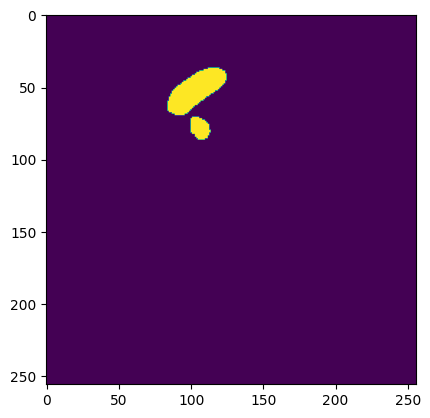

In [6]:
[t,p] = train_gen.__getitem__(90)
print(t.shape)
plt.imshow(p[0,:,:,0])

In [7]:
np.unique(p)

array([0, 1], dtype=uint8)

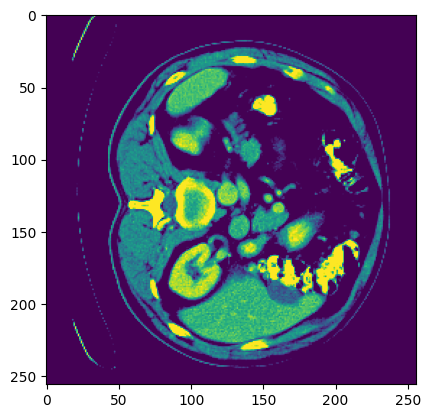

In [8]:
plt.imshow(t[0,:,:,0])

In [6]:
import encoder_layers as encoder_layers
import decoder_layers as decoder_layers
from resnet_v2 import  resnet_embeddings
from transformerskip import tskip
import tensorflow_addons as tfa
import matplotlib.pyplot as plt
import utils as utils
import math

tfk = tf.keras
tfkl = tfk.layers
tfm = tf.math

/home/rabeea/anaconda3/envs/beea/lib/python3.10/site-packages/tensorflow_addons/utils/tfa_eol_msg.py:23: UserWarning: 

TensorFlow Addons (TFA) has ended development and introduction of new features.
TFA has entered a minimal maintenance and release mode until a planned end of life in May 2024.
Please modify downstream libraries to take dependencies from other repositories in our TensorFlow community (e.g. Keras, Keras-CV, and Keras-NLP). 

For more information see: https://github.com/tensorflow/addons/issues/2807 

  warnings.warn(
/home/rabeea/anaconda3/envs/beea/lib/python3.10/site-packages/tensorflow_addons/utils/ensure_tf_install.py:53: UserWarning: Tensorflow Addons supports using Python ops for all Tensorflow versions above or equal to 2.10.0 and strictly below 2.13.0 (nightly versions are not supported). 
 The versions of TensorFlow you are currently using is 2.8.0 and is not supported. 
Some things might work, some things might not.
If you were to encounter a bug, do not file 

In [7]:
def TransUNet(image_size=256, 
                patch_size=16, 
                hybrid=True,
                grid=(14,14), 
                hidden_size=768,
                n_layers=12,
                n_heads=12,
                mlp_dim=3072,
                dropout=0.1,
                decoder_channels=[256,128,64,16],
                n_skip=3,
                num_classes=1,
                final_act='sigmoid',
                pretrain=False,
                freeze_enc_cnn=True,
                name='TransUNet'):
    # Tranformer Encoder
    assert image_size % patch_size == 0, "image_size must be a multiple of patch_size"
    x = tf.keras.layers.Input(shape=(image_size, image_size, 1))

    # Embedding
    if hybrid:
        grid_size = grid
        patch_size = image_size // 16 // grid_size[0]
        if patch_size == 0:
            patch_size = 1

        resnet50v2, features = resnet_embeddings(x, image_size=image_size, n_skip=n_skip, pretrain=pretrain)
        print(len(features))
        for d in features:
            print(d.shape)
        if freeze_enc_cnn:
            resnet50v2.trainable = False
        y = resnet50v2.get_layer("conv4_block6_preact_relu").output
        x = resnet50v2.input
    else:
        y = x
        features = None

    y = tfkl.Conv2D(
        filters=hidden_size,
        kernel_size=patch_size,
        strides=patch_size,
        padding="valid",
        name="embedding",
        trainable=True
    )(y)
    y = tfkl.Reshape(
        (y.shape[1] * y.shape[2], hidden_size))(y)
    y = encoder_layers.AddPositionEmbs(
        name="Transformer/posembed_input", trainable=True)(y)

    y = tfkl.Dropout(0.1)(y)

    # Transformer/Encoder
    for n in range(n_layers):
        y, _ = encoder_layers.TransformerBlock(
            n_heads=n_heads,
            mlp_dim=mlp_dim,
            dropout=dropout,
            name=f"Transformer/encoderblock_{n}",
            trainable=True
        )(y)
    y = tfkl.LayerNormalization(
        epsilon=1e-6, name="Transformer/encoder_norm"
    )(y)

    n_patch_sqrt = int(math.sqrt(y.shape[1]))

    y = tfkl.Reshape(
        target_shape=[n_patch_sqrt, n_patch_sqrt, hidden_size])(y)

    # Decoder CUP
    if len(decoder_channels):
#         #print('after reverting')
#         features = features[::-1]
#         #for d in features:
#         #    print(d.shape)
#         features = tskip(features,embedding_dim = 4, dim = 8, heads = 4)
#         #for d in features:
#         #    print(d.shape)
#         features = features[::-1]
#         #for d in features:
#         #    print(d.shape)
        y = decoder_layers.DecoderCup(decoder_channels=decoder_channels, n_skip=n_skip)(y, features)

    # Segmentation Head
    y = decoder_layers.SegmentationHead(num_classes=num_classes, final_act=final_act)(y)

    # Build Model
    model =  tfk.models.Model(inputs=x, outputs=y, name=name)
    
    # Load Pretrain Weights
    if pretrain:
        load_pretrained(model)
        
    return model


In [8]:
a = TransUNet()
a.compile(optimizer = tf.keras.optimizers.SGD(lr = 1e-3), loss=dice_loss, metrics = [dice_coef])
a.summary()

2023-08-24 13:22:35.229730: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1525] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 38218 MB memory:  -> device: 0, name: NVIDIA A100-PCIE-40GB, pci bus id: 0000:5e:00.0, compute capability: 8.0


3
(None, 32, 32, 512)
(None, 64, 64, 256)
(None, 128, 128, 64)
Model: "TransUNet"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 256, 256, 1  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 262, 262, 1)  0           ['input_2[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 128, 128, 64  3200        ['conv1_pad[0][0]']              
                                )                                                                 
                           

 ormalization)                                                                                    
                                                                                                  
 conv2_block3_preact_relu (Acti  (None, 64, 64, 256)  0          ['conv2_block3_preact_bn[0][0]'] 
 vation)                                                                                          
                                                                                                  
 conv2_block3_1_conv (Conv2D)   (None, 64, 64, 64)   16384       ['conv2_block3_preact_relu[0][0]'
                                                                 ]                                
                                                                                                  
 conv2_block3_1_bn (BatchNormal  (None, 64, 64, 64)  256         ['conv2_block3_1_conv[0][0]']    
 ization)                                                                                         
          

                                                                                                  
 conv3_block2_2_conv (Conv2D)   (None, 32, 32, 128)  147456      ['conv3_block2_2_pad[0][0]']     
                                                                                                  
 conv3_block2_2_bn (BatchNormal  (None, 32, 32, 128)  512        ['conv3_block2_2_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv3_block2_2_relu (Activatio  (None, 32, 32, 128)  0          ['conv3_block2_2_bn[0][0]']      
 n)                                                                                               
                                                                                                  
 conv3_block2_3_conv (Conv2D)   (None, 32, 32, 512)  66048       ['conv3_block2_2_relu[0][0]']    
          

                                                                                                  
 conv4_block1_1_conv (Conv2D)   (None, 16, 16, 256)  131072      ['conv4_block1_preact_relu[0][0]'
                                                                 ]                                
                                                                                                  
 conv4_block1_1_bn (BatchNormal  (None, 16, 16, 256)  1024       ['conv4_block1_1_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv4_block1_1_relu (Activatio  (None, 16, 16, 256)  0          ['conv4_block1_1_bn[0][0]']      
 n)                                                                                               
                                                                                                  
 conv4_blo

 ization)                                                                                         
                                                                                                  
 conv4_block3_2_relu (Activatio  (None, 16, 16, 256)  0          ['conv4_block3_2_bn[0][0]']      
 n)                                                                                               
                                                                                                  
 conv4_block3_3_conv (Conv2D)   (None, 16, 16, 1024  263168      ['conv4_block3_2_relu[0][0]']    
                                )                                                                 
                                                                                                  
 conv4_block3_out (Add)         (None, 16, 16, 1024  0           ['conv4_block2_out[0][0]',       
                                )                                 'conv4_block3_3_conv[0][0]']    
          

                                                                                                  
 reshape (Reshape)              (None, 256, 768)     0           ['embedding[0][0]']              
                                                                                                  
 Transformer/posembed_input (Ad  (None, 256, 768)    196608      ['reshape[0][0]']                
 dPositionEmbs)                                                                                   
                                                                                                  
 dropout (Dropout)              (None, 256, 768)     0           ['Transformer/posembed_input[0][0
                                                                 ]']                              
                                                                                                  
 Transformer/encoderblock_0 (Tr  ((None, 256, 768),  7087872     ['dropout[0][0]']                
 ansformer

/home/rabeea/anaconda3/envs/beea/lib/python3.10/site-packages/keras/optimizer_v2/gradient_descent.py:102: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(SGD, self).__init__(name, **kwargs)


In [9]:
from tensorflow.keras.callbacks import TensorBoard
from tensorflow.keras.callbacks import ModelCheckpoint
filepath = r"/home/rabeea/logs/transunet_spleen/4layers_lr3_f64_l12_350.h5"
checkpoint = ModelCheckpoint(filepath, monitor='val_dice_coef', save_best_only=True, mode='max')
callbacks_list = [checkpoint]

In [13]:
history = a.fit(train_gen,
                      validation_data=valid_gen,epochs=epochs,callbacks=callbacks_list)

Epoch 1/350


2023-08-22 23:27:13.051907: I tensorflow/stream_executor/cuda/cuda_dnn.cc:368] Loaded cuDNN version 8801
2023-08-22 23:27:14.279198: I tensorflow/stream_executor/cuda/cuda_blas.cc:1786] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.


2463/2463 [==============================] - 291s 110ms/step - loss: 1.1276 - dice_coef: 0.0164 - val_loss: 1.1134 - val_dice_coef: 0.0305
Epoch 2/350
2463/2463 [==============================] - 264s 107ms/step - loss: 1.1195 - dice_coef: 0.0243 - val_loss: 1.1230 - val_dice_coef: 0.0207
Epoch 3/350
2463/2463 [==============================] - 261s 106ms/step - loss: 1.1080 - dice_coef: 0.0357 - val_loss: 1.1163 - val_dice_coef: 0.0273
Epoch 4/350
2463/2463 [==============================] - 256s 104ms/step - loss: 1.0954 - dice_coef: 0.0481 - val_loss: 1.1259 - val_dice_coef: 0.0176
Epoch 5/350
2463/2463 [==============================] - 261s 106ms/step - loss: 1.0762 - dice_coef: 0.0672 - val_loss: 1.0844 - val_dice_coef: 0.0589
Epoch 6/350
2463/2463 [==============================] - 261s 106ms/step - loss: 1.0521 - dice_coef: 0.0912 - val_loss: 1.0537 - val_dice_coef: 0.0895
Epoch 7/350
2463/2463 [==============================] - 258s 105ms/step - loss: 1.0290 - dice_coef: 0.114

2463/2463 [==============================] - 263s 107ms/step - loss: 0.4073 - dice_coef: 0.7301 - val_loss: 0.4660 - val_dice_coef: 0.6713
Epoch 56/350
2463/2463 [==============================] - 260s 106ms/step - loss: 0.4072 - dice_coef: 0.7301 - val_loss: 0.4659 - val_dice_coef: 0.6713
Epoch 57/350
2463/2463 [==============================] - 258s 105ms/step - loss: 0.4070 - dice_coef: 0.7301 - val_loss: 0.4658 - val_dice_coef: 0.6713
Epoch 58/350
2463/2463 [==============================] - 271s 110ms/step - loss: 0.4069 - dice_coef: 0.7301 - val_loss: 0.4656 - val_dice_coef: 0.6713
Epoch 59/350
2463/2463 [==============================] - 263s 107ms/step - loss: 0.4068 - dice_coef: 0.7301 - val_loss: 0.4655 - val_dice_coef: 0.6713
Epoch 60/350
2463/2463 [==============================] - 269s 109ms/step - loss: 0.4066 - dice_coef: 0.7301 - val_loss: 0.4653 - val_dice_coef: 0.6713
Epoch 61/350
2463/2463 [==============================] - 264s 107ms/step - loss: 0.4065 - dice_coef:

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



2463/2463 [==============================] - 265s 108ms/step - loss: 0.4035 - dice_coef: 0.7308 - val_loss: 0.4631 - val_dice_coef: 0.6711
Epoch 80/350
1058/2463 [===========>..................] - ETA: 2:16 - loss: 0.4048 - dice_coef: 0.7294

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



2463/2463 [==============================] - 274s 111ms/step - loss: 0.4027 - dice_coef: 0.7309 - val_loss: 0.8538 - val_dice_coef: 0.2797
Epoch 85/350
1561/2463 [==================>...........] - ETA: 1:30 - loss: 0.4050 - dice_coef: 0.7285

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



2463/2463 [==============================] - 274s 111ms/step - loss: 0.4029 - dice_coef: 0.7302 - val_loss: 0.4618 - val_dice_coef: 0.6712
Epoch 89/350
 719/2463 [=======>......................] - ETA: 2:49 - loss: 0.4064 - dice_coef: 0.7266

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



2312/2463 [===========================>..] - ETA: 15s - loss: 0.4021 - dice_coef: 0.7307

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



1535/2463 [=================>............] - ETA: 1:36 - loss: 0.4170 - dice_coef: 0.7153

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



2463/2463 [==============================] - 263s 107ms/step - loss: 0.4020 - dice_coef: 0.7302 - val_loss: 0.4608 - val_dice_coef: 0.6714
Epoch 96/350
 652/2463 [======>.......................] - ETA: 3:03 - loss: 0.4152 - dice_coef: 0.7169

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



2356/2463 [===========================>..] - ETA: 10s - loss: 0.4015 - dice_coef: 0.7302

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



2463/2463 [==============================] - 264s 107ms/step - loss: 0.4013 - dice_coef: 0.7302 - val_loss: 0.4600 - val_dice_coef: 0.6715
Epoch 101/350
1258/2463 [==============>...............] - ETA: 2:00 - loss: 0.3931 - dice_coef: 0.7383

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



2463/2463 [==============================] - 263s 107ms/step - loss: 0.4008 - dice_coef: 0.7302 - val_loss: 0.4596 - val_dice_coef: 0.6714
Epoch 105/350
 273/2463 [==>...........................] - ETA: 3:45 - loss: 0.3943 - dice_coef: 0.7367

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



2463/2463 [==============================] - 267s 108ms/step - loss: 0.4007 - dice_coef: 0.7302 - val_loss: 0.4594 - val_dice_coef: 0.6714
Epoch 106/350
1629/2463 [==================>...........] - ETA: 1:21 - loss: 0.4089 - dice_coef: 0.7219

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



2463/2463 [==============================] - 264s 107ms/step - loss: 0.3999 - dice_coef: 0.7305 - val_loss: 0.4589 - val_dice_coef: 0.6715
Epoch 110/350
 649/2463 [======>.......................] - ETA: 3:09 - loss: 0.3775 - dice_coef: 0.7528

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



2105/2463 [========================>.....] - ETA: 34s - loss: 0.3996 - dice_coef: 0.7306

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



2463/2463 [==============================] - 265s 108ms/step - loss: 0.3996 - dice_coef: 0.7302 - val_loss: 0.4583 - val_dice_coef: 0.6714
Epoch 115/350
 936/2463 [==========>...................] - ETA: 2:35 - loss: 0.4025 - dice_coef: 0.7271

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



2463/2463 [==============================] - 260s 105ms/step - loss: 0.3993 - dice_coef: 0.7302 - val_loss: 0.4580 - val_dice_coef: 0.6714
Epoch 117/350
 203/2463 [=>............................] - ETA: 3:39 - loss: 0.3703 - dice_coef: 0.7592

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



1469/2463 [================>.............] - ETA: 1:40 - loss: 0.3993 - dice_coef: 0.7298

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



2463/2463 [==============================] - 270s 110ms/step - loss: 0.3986 - dice_coef: 0.7303 - val_loss: 0.4573 - val_dice_coef: 0.6715
Epoch 122/350
 683/2463 [=======>......................] - ETA: 3:01 - loss: 0.3886 - dice_coef: 0.7402

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



1985/2463 [=======================>......] - ETA: 47s - loss: 0.3953 - dice_coef: 0.7332

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



2463/2463 [==============================] - 263s 107ms/step - loss: 0.3980 - dice_coef: 0.7302 - val_loss: 0.4567 - val_dice_coef: 0.6714
Epoch 127/350
1251/2463 [==============>...............] - ETA: 1:59 - loss: 0.4105 - dice_coef: 0.7177

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



2463/2463 [==============================] - 263s 107ms/step - loss: 0.3979 - dice_coef: 0.7300 - val_loss: 0.8237 - val_dice_coef: 0.3041
Epoch 130/350
  85/2463 [>.............................] - ETA: 3:50 - loss: 0.3941 - dice_coef: 0.7337

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



2463/2463 [==============================] - 260s 105ms/step - loss: 0.3949 - dice_coef: 0.7327 - val_loss: 0.4564 - val_dice_coef: 0.6712
Epoch 132/350
1642/2463 [===================>..........] - ETA: 1:20 - loss: 0.4015 - dice_coef: 0.7261

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



2463/2463 [==============================] - 263s 107ms/step - loss: 0.3971 - dice_coef: 0.7302 - val_loss: 0.4561 - val_dice_coef: 0.6711
Epoch 135/350
 676/2463 [=======>......................] - ETA: 2:55 - loss: 0.3768 - dice_coef: 0.7505

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



1968/2463 [======================>.......] - ETA: 47s - loss: 0.3946 - dice_coef: 0.7323

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



2463/2463 [==============================] - 264s 107ms/step - loss: 0.3964 - dice_coef: 0.7303 - val_loss: 0.4552 - val_dice_coef: 0.6714
Epoch 140/350
1030/2463 [===========>..................] - ETA: 2:18 - loss: 0.4006 - dice_coef: 0.7260

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



2287/2463 [==========================>...] - ETA: 18s - loss: 0.3943 - dice_coef: 0.7321

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



1374/2463 [===============>..............] - ETA: 1:52 - loss: 0.3999 - dice_coef: 0.7261

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



2463/2463 [==============================] - 260s 106ms/step - loss: 0.3955 - dice_coef: 0.7302 - val_loss: 0.4543 - val_dice_coef: 0.6714
Epoch 148/350
 202/2463 [=>............................] - ETA: 3:43 - loss: 0.3432 - dice_coef: 0.7824

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



1697/2463 [===================>..........] - ETA: 1:14 - loss: 0.3973 - dice_coef: 0.7281

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



2463/2463 [==============================] - 263s 107ms/step - loss: 0.3949 - dice_coef: 0.7302 - val_loss: 0.4681 - val_dice_coef: 0.6569
Epoch 153/350
 558/2463 [=====>........................] - ETA: 3:06 - loss: 0.4120 - dice_coef: 0.7130

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



2008/2463 [=======================>......] - ETA: 45s - loss: 0.3961 - dice_coef: 0.7287

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



2463/2463 [==============================] - 259s 105ms/step - loss: 0.3942 - dice_coef: 0.7304 - val_loss: 0.4795 - val_dice_coef: 0.6450
Epoch 157/350
 500/2463 [=====>........................] - ETA: 3:11 - loss: 0.3939 - dice_coef: 0.7306

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



2335/2463 [===========================>..] - ETA: 12s - loss: 0.3979 - dice_coef: 0.7262

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



2463/2463 [==============================] - 260s 106ms/step - loss: 0.3929 - dice_coef: 0.7312 - val_loss: 0.4577 - val_dice_coef: 0.6663
Epoch 162/350
 904/2463 [==========>...................] - ETA: 2:38 - loss: 0.3988 - dice_coef: 0.7251

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



2463/2463 [==============================] - 270s 110ms/step - loss: 0.3934 - dice_coef: 0.7302 - val_loss: 0.4826 - val_dice_coef: 0.6409
Epoch 166/350
 191/2463 [=>............................] - ETA: 3:46 - loss: 0.4059 - dice_coef: 0.7176

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



2463/2463 [==============================] - 266s 108ms/step - loss: 0.3932 - dice_coef: 0.7302 - val_loss: 0.4757 - val_dice_coef: 0.6477
Epoch 167/350
1443/2463 [================>.............] - ETA: 1:42 - loss: 0.3958 - dice_coef: 0.7275

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



2463/2463 [==============================] - 265s 108ms/step - loss: 0.3928 - dice_coef: 0.7302 - val_loss: 0.4539 - val_dice_coef: 0.6690
Epoch 171/350
 515/2463 [=====>........................] - ETA: 3:19 - loss: 0.3690 - dice_coef: 0.7539

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



1981/2463 [=======================>......] - ETA: 48s - loss: 0.3891 - dice_coef: 0.7336

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



2463/2463 [==============================] - 269s 109ms/step - loss: 0.3921 - dice_coef: 0.7302 - val_loss: 0.4595 - val_dice_coef: 0.6628
Epoch 176/350
 844/2463 [=========>....................] - ETA: 2:37 - loss: 0.3871 - dice_coef: 0.7352

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



2463/2463 [==============================] - 264s 107ms/step - loss: 0.3919 - dice_coef: 0.7302 - val_loss: 0.4621 - val_dice_coef: 0.6600
Epoch 178/350
  52/2463 [..............................] - ETA: 3:45 - loss: 0.3141 - dice_coef: 0.8080

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



1221/2463 [=============>................] - ETA: 2:00 - loss: 0.4002 - dice_coef: 0.7214

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



2463/2463 [==============================] - 264s 107ms/step - loss: 0.3913 - dice_coef: 0.7302 - val_loss: 0.4503 - val_dice_coef: 0.6712
Epoch 183/350
 452/2463 [====>.........................] - ETA: 3:24 - loss: 0.3711 - dice_coef: 0.7504

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



1565/2463 [==================>...........] - ETA: 1:31 - loss: 0.4035 - dice_coef: 0.7175

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



2463/2463 [==============================] - 264s 107ms/step - loss: 0.3907 - dice_coef: 0.7302 - val_loss: 0.4568 - val_dice_coef: 0.6641
Epoch 188/350
 780/2463 [========>.....................] - ETA: 2:50 - loss: 0.4061 - dice_coef: 0.7147

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



1964/2463 [======================>.......] - ETA: 50s - loss: 0.3938 - dice_coef: 0.7267

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



2463/2463 [==============================] - 274s 111ms/step - loss: 0.3901 - dice_coef: 0.7302 - val_loss: 0.4492 - val_dice_coef: 0.6711
Epoch 193/350
1169/2463 [=============>................] - ETA: 2:10 - loss: 0.3968 - dice_coef: 0.7234

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



2299/2463 [===========================>..] - ETA: 15s - loss: 0.3911 - dice_coef: 0.7288

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



2463/2463 [==============================] - 266s 108ms/step - loss: 0.3895 - dice_coef: 0.7302 - val_loss: 0.4491 - val_dice_coef: 0.6705
Epoch 198/350
1485/2463 [=================>............] - ETA: 1:39 - loss: 0.3951 - dice_coef: 0.7245

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



2463/2463 [==============================] - 255s 104ms/step - loss: 0.3890 - dice_coef: 0.7302 - val_loss: 0.4491 - val_dice_coef: 0.6701
Epoch 202/350
1456/2463 [================>.............] - ETA: 1:42 - loss: 0.3844 - dice_coef: 0.7348

KeyboardInterrupt: 

In [10]:
a.load_weights(filepath)

In [ ]:
acc = history.history['dice_coef']
val_acc = history.history['val_dice_coef']
print('training dice: ',max(acc))
print('validation dice: ',max(val_acc))

In [ ]:
#plot the training and validation IoU and loss at each epoch
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(loss) + 1)
plt.plot(epochs, loss, 'y', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [ ]:
acc = history.history['dice_coef']
val_acc = history.history['val_dice_coef']

plt.plot(epochs, acc, 'y', label='Training Dice coefficient')
plt.plot(epochs, val_acc, 'r', label='Validation Dice Coefficient')
plt.title('Training and validation Dice coefficient')
plt.xlabel('Epochs')
plt.ylabel('Dice Coefficient')
plt.legend()
plt.show()

In [11]:
#test_gen = DataGen(image_size,testpath, batch_size=batch_size)
tr_dice_6=[]
tr_dice_5=[]
tr_dice_4=[]
tr_dice_3=[]
tr_dice_2=[]
tr_dice_9=[]
tr_dice_8=[]
tr_dice_7=[]
tr_dice_1=[]
tr_dice_05=[]
tr_dice_01=[]
tr_dice_005=[]
tr_dice_001=[]
tr_dice_0005=[]
tr_dice_0001=[]
for k in tqdm(range(len(testpath))):
    y_pred=a.predict(test_gen.__getitem__(k)[0])
    true_msk=test_gen.__getitem__(k)[1]
    y_pred_argmax=np.where(y_pred>0.9,1,0)
    tr_dice_9.append(compute_dice(y_pred_argmax, true_msk))
    y_pred_argmax=np.where(y_pred>0.8,1,0)
    tr_dice_8.append(compute_dice(y_pred_argmax, true_msk))
    y_pred_argmax=np.where(y_pred>0.7,1,0)
    tr_dice_7.append(compute_dice(y_pred_argmax, true_msk))
    y_pred_argmax=np.where(y_pred>0.6,1,0)
    tr_dice_6.append(compute_dice(y_pred_argmax, true_msk))
    y_pred_argmax=np.where(y_pred>0.5,1,0)
    tr_dice_5.append(compute_dice(y_pred_argmax, true_msk))
    y_pred_argmax=np.where(y_pred>0.4,1,0)
    tr_dice_4.append(compute_dice(y_pred_argmax, true_msk))
    y_pred_argmax=np.where(y_pred>0.3,1,0)
    tr_dice_3.append(compute_dice(y_pred_argmax, true_msk))
    y_pred_argmax=np.where(y_pred>0.2,1,0)
    tr_dice_2.append(compute_dice(y_pred_argmax, true_msk))
    y_pred_argmax=np.where(y_pred>0.1,1,0)
    tr_dice_1.append(compute_dice(y_pred_argmax, true_msk))
    y_pred_argmax=np.where(y_pred>0.05,1,0)
    tr_dice_05.append(compute_dice(y_pred_argmax, true_msk))
    y_pred_argmax=np.where(y_pred>0.01,1,0)
    tr_dice_01.append(compute_dice(y_pred_argmax, true_msk))
    y_pred_argmax=np.where(y_pred>0.005,1,0)
    tr_dice_005.append(compute_dice(y_pred_argmax, true_msk))
    y_pred_argmax=np.where(y_pred>0.001,1,0)
    tr_dice_001.append(compute_dice(y_pred_argmax, true_msk))
    y_pred_argmax=np.where(y_pred>0.0005,1,0)
    tr_dice_0005.append(compute_dice(y_pred_argmax, true_msk))
    y_pred_argmax=np.where(y_pred>0.0001,1,0)
    tr_dice_0001.append(compute_dice(y_pred_argmax, true_msk))
    
#     except:
#         print(k)
#         break
print('at 0.9: dice: ',np.mean(tr_dice_9))
print('at 0.8: dice: ',np.mean(tr_dice_8))
print('at 0.7: dice: ',np.mean(tr_dice_7))
print('at 0.6: dice: ',np.mean(tr_dice_6))
print('at 0.5: dice: ',np.mean(tr_dice_5))
print('at 0.4: dice: ',np.mean(tr_dice_4))
print('at 0.3: dice: ',np.mean(tr_dice_3))
print('at 0.2: dice: ',np.mean(tr_dice_2))
print('at 0.1: dice: ',np.mean(tr_dice_1))
print('at 0.05: dice: ',np.mean(tr_dice_05))
print('at 0.01: dice: ',np.mean(tr_dice_01))
print('at 0.005: dice: ',np.mean(tr_dice_005))
print('at 0.001: dice: ',np.mean(tr_dice_001))
print('at 0.0005: dice: ',np.mean(tr_dice_0005))
print('at 0.0001: dice: ',np.mean(tr_dice_0001))

  0%|                                                   | 0/801 [00:00<?, ?it/s]2023-08-24 13:24:06.400555: I tensorflow/stream_executor/cuda/cuda_dnn.cc:368] Loaded cuDNN version 8801
2023-08-24 13:24:07.429137: I tensorflow/stream_executor/cuda/cuda_blas.cc:1786] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.
/tmp/ipykernel_3242479/1832244335.py:72: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  im1 = np.asarray(im1).astype(np.bool)
/tmp/ipykernel_3242479/1832244335.py:73: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any

at 0.9: dice:  0.6779026217228464
at 0.8: dice:  0.6779026217228464
at 0.7: dice:  0.6779026217228464
at 0.6: dice:  0.6779026217228464
at 0.5: dice:  0.6779026217228464
at 0.4: dice:  0.6779026217228464
at 0.3: dice:  0.6779026217228464
at 0.2: dice:  0.6779026217228464
at 0.1: dice:  0.6779026217228464
at 0.05: dice:  0.6779026217228464
at 0.01: dice:  0.6802191831575222
at 0.005: dice:  0.6834667679359866
at 0.001: dice:  0.664597813175017
at 0.0005: dice:  0.5646725669648994
at 0.0001: dice:  0.08186560230517306
